In [1]:
import pprint
import boto3

import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from nltk.corpus import stopwords
# from nltk.tokenize import sent_tokenize, word_tokenize
# from nltk.sentiment import SentimentIntensityAnalyzer

# from textblob import TextBlob
# from textblob.sentiments import PatternAnalyzer, NaiveBayesAnalyzer
# from textblob.tokenizers import WordTokenizer, SentenceTokenizer
# from nrclex import NRCLex

from scipy import stats
from collections import Counter
import math
from pathlib import Path

## 1. Load the data

In [3]:
# Load transcript
# TRANSCRIPT_FILE_PATH = Path(__file__).parent / "debate_transcript.txt"
TRANSCRIPT_FILE_PATH = "./debate_transcript.txt"

# read the transcript line by line
transcript = []
with open(TRANSCRIPT_FILE_PATH, 'r') as file:
    for line in file:
        if line.strip():    # skip the empty lines
            transcript.append(line.rstrip())

In [4]:
# Data preprocessing
## Extract relevant parts of the data
# separate transcript by each candidate
harris_transcript = [line for line in transcript if line.startswith('VICE PRESIDENT KAMALA HARRIS:')]
trump_transcript = [line for line in transcript if line.startswith('FORMER PRESIDENT DONALD TRUMP:')]

# extract only the speeches of each candidate
# harris
start_pattern = r'VICE PRESIDENT KAMALA HARRIS:\s+'
harris_transcript = [re.sub(start_pattern, '', line) for line in harris_transcript]

# trump
start_pattern = r'FORMER PRESIDENT DONALD TRUMP:\s+'
trump_transcript = [re.sub(start_pattern, '', line) for line in trump_transcript]

## 2. Setting up AWS Comprehend Client

In [5]:
# use comprehend to compare the overall sentiment between the 2 candidates
# Initialize pretty printer for better output formatting
pp = pprint.PrettyPrinter(indent=2)

# Create Comprehend client
comprehend = boto3.client(service_name="comprehend", region_name="eu-west-1")

In [6]:
# AWS Comprehend pricing per unit (up to 10M units) for sentiment analysis function
SENTIMENT_ANALYSIS_PRICE_PER_UNIT = 0.0001     # 1 unit = 100 characters

# # AWS Comprehend pricing per unit (up to 10M units) for entity recognition function
# TARGETED_SENTIMENT_PRICE_PER_UNIT = 0.0001
ENTITY_RECOGNITION_PRICE_PER_UNIT = 0.0001

# Total price tracker
TOTAL_PRICE = 0

## 3. Call Batch Sentiment Analysis API

In [7]:
# Detect sentiment of Harris over time
# using max batch size of 25
MAX_BATCH_SIZE = 25

harris_sentiment_scores = []
# track the number of characters
n_chars_harris = 0
for i in range(0, len(harris_transcript), MAX_BATCH_SIZE):
    # extract the batch
    text_batch = harris_transcript[i:min(i+MAX_BATCH_SIZE, len(harris_transcript))]
    # calculate the number of characters in the batch
    n_chars_harris += sum([len(i) for i in text_batch])
    # call the batch detect sentiment API
    batch_response = comprehend.batch_detect_sentiment(TextList=text_batch, LanguageCode='en')
    
    for response in batch_response['ResultList']:
        sentiment_score = response['SentimentScore']
        harris_sentiment_scores.append(sentiment_score)

# calculate the number of units (round up to the nearest unit)
n_units_harris = math.ceil(n_chars_harris / 100)
print('\nHarris:')
print(f'Total number of units analyzed: {n_units_harris}')

# calculate the cost
cost_harris = n_units_harris * SENTIMENT_ANALYSIS_PRICE_PER_UNIT
TOTAL_PRICE += cost_harris
print(f'Added price: {cost_harris:.4f}')


Harris:
Total number of units analyzed: 328
Added price: 0.0328


In [8]:
# Detect sentiment of Trump over time
# using max batch size of 25
MAX_BATCH_SIZE = 25

trump_sentiment_scores = []
# track the number of characters
n_chars_trump = 0
for i in range(0, len(trump_transcript), MAX_BATCH_SIZE):
    # extract the batch
    text_batch = trump_transcript[i:min(i+MAX_BATCH_SIZE, len(trump_transcript))]
    # calculate the number of characters in the batch
    n_chars_trump += sum([len(i) for i in text_batch])
    # call the batch detect sentiment API
    batch_response = comprehend.batch_detect_sentiment(TextList=text_batch, LanguageCode='en')
    
    for response in batch_response['ResultList']:
        sentiment_score = response['SentimentScore']
        trump_sentiment_scores.append(sentiment_score)

# calculate the number of units (round up to the nearest unit)
n_units_trump = math.ceil(n_chars_trump / 100)
print('\nTrump:')
print(f'Total number of units analyzed: {n_units_trump}')

# calculate the cost
cost_trump = n_units_trump * SENTIMENT_ANALYSIS_PRICE_PER_UNIT
TOTAL_PRICE += cost_trump
print(f'Added price: {cost_trump:.4f}')


Trump:
Total number of units analyzed: 431
Added price: 0.0431


In [9]:
# Check total price so far
print(f'Total cost so far: ${TOTAL_PRICE:.4f}')

Total cost so far: $0.0759


In [10]:
SENTIMENT_LIST = harris_sentiment_scores[0].keys()

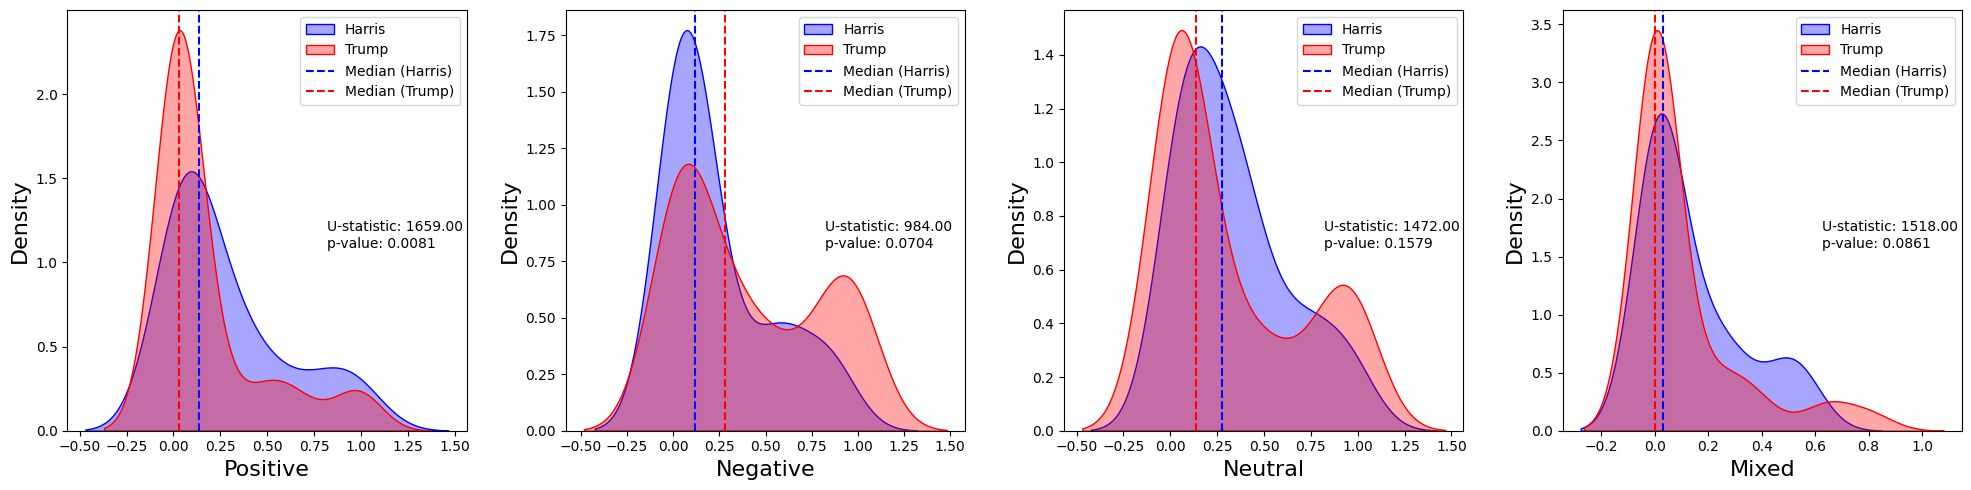

In [11]:
# Plot distribution Harris and Trump sentiment score distribution for each sentiment
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# axes.sharey()

for ax, sentiment in zip(axes.flatten(), SENTIMENT_LIST):
    harris_ = [i[sentiment] for i in harris_sentiment_scores]
    trump_ = [i[sentiment] for i in trump_sentiment_scores]

    # plot distribution
    sns.kdeplot(harris_, color='b', fill=True, alpha=0.35, label='Harris', ax=ax)
    sns.kdeplot(trump_, color='r', fill=True, alpha=0.35, label='Trump', ax=ax)

    # add vertical lines for medians
    ax.axvline(np.median(harris_), color='b', linestyle='--', label='Median (Harris)')
    ax.axvline(np.median(trump_), color='r', linestyle='--', label='Median (Trump)')
    # add labels and titles
    ax.set_xlabel(f'{sentiment}', fontsize=16)
    ax.set_ylabel('Density', fontsize=16)
    # add annotation box for results of Mann-Whitney U test
    U, p = stats.mannwhitneyu(harris_, trump_)
    # Add a text box with the D-statistic and p-value
    textstr = f'U-statistic: {U:.2f}\np-value: {p:.4f}'
    props = dict(boxstyle='round', facecolor='none', alpha=0.5, edgecolor='none')
    ax.text(0.65, 0.5, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    ax.legend()
plt.tight_layout()
plt.show()

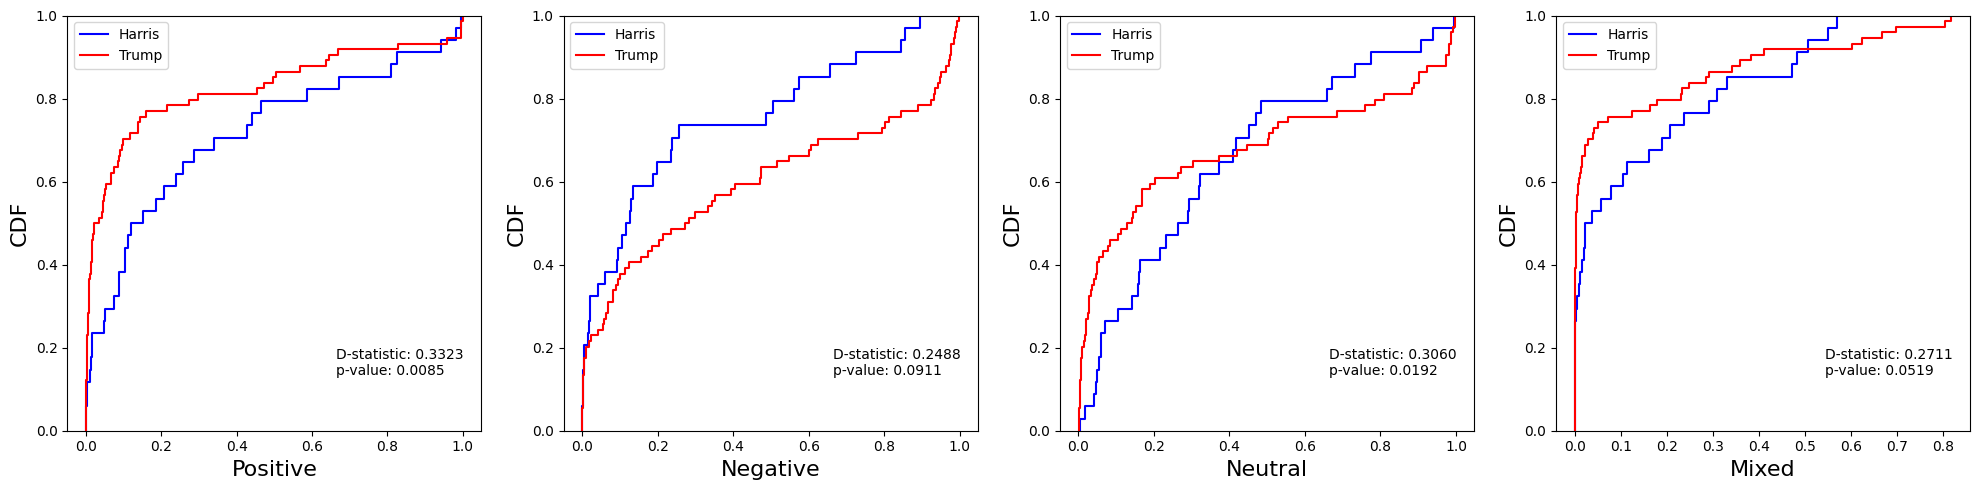

In [12]:
# Compare Harris and Trump sentiment score distribution for each sentiment
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# axes.sharey()

for ax, sentiment in zip(axes.flatten(), SENTIMENT_LIST):
    harris_ = [i[sentiment] for i in harris_sentiment_scores]
    trump_ = [i[sentiment] for i in trump_sentiment_scores]

    # plot cumulative distribution
    sns.ecdfplot(harris_, label='Harris', color='b', ax=ax)
    sns.ecdfplot(trump_, label='Trump', color='r', ax=ax)
    # add labels and titles
    ax.set_xlabel(f'{sentiment}', fontsize=16)
    ax.set_ylabel('CDF', fontsize=16)
    # add annotation box for results of KS-test
    ks = stats.ks_2samp(harris_, trump_)
    d_stat, p_val = ks.statistic, ks.pvalue
    # Add a text box with the D-statistic and p-value
    textstr = f'D-statistic: {d_stat:.4f}\np-value: {p_val:.4f}'
    props = dict(boxstyle='round', facecolor='none', alpha=0.5, edgecolor='none')
    ax.text(0.65, 0.2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    ax.legend()

plt.tight_layout()
plt.show()

In [13]:
# # plot the fluctuations of sentiment scores over time
# for sentiment in SENTIMENT_LIST:
#     harris_ = [i[sentiment] for i in harris_sentiment_scores]
#     trump_ = [i[sentiment] for i in trump_sentiment_scores]

#     fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
#     ax = ax.ravel()
#     # plot cumulative distribution
#     ax[0].plot(harris_, color='b')
#     ax[1].plot(trump_, color='r')
#     # add labels and titles
#     fig.suptitle(f'{sentiment}', fontsize=16)
#     ax[0].set_ylabel('Sentiment score (Harris)')
#     ax[1].set_ylabel('Sentiment score (Trump)')
    
#     # fig.legend()

#     plt.tight_layout()
#     plt.show()

## 4. call Batch Detect Entities API

In [14]:
# Detect entities in Harris's speech
# using max batch size of 25
MAX_BATCH_SIZE = 25

harris_entities_ls = []
# track the number of characters
n_chars_harris = 0
for i in range(0, len(harris_transcript), MAX_BATCH_SIZE):
    # extract the batch
    text_batch = harris_transcript[i:min(i+MAX_BATCH_SIZE, len(harris_transcript))]
    # calculate the number of characters in the batch
    n_chars_harris += sum([len(i) for i in text_batch])
    # call the batch detect sentiment API
    batch_response = comprehend.batch_detect_entities(TextList=text_batch, LanguageCode='en')
    
    for response in batch_response['ResultList']:
        entities = response['Entities']
        harris_entities_ls.extend([i['Text'] for i in entities])

# calculate the number of units (round up to the nearest unit)
n_units_harris = math.ceil(n_chars_harris / 100)
print('\nHarris:')
print(f'Total number of units analyzed: {n_units_harris}')

# calculate the cost
cost_harris = n_units_harris * ENTITY_RECOGNITION_PRICE_PER_UNIT
TOTAL_PRICE += cost_harris
print(f'Added price: {cost_harris:.4f}')


Harris:
Total number of units analyzed: 328
Added price: 0.0328


In [15]:
# Detect entities in Trump's speech
# using max batch size of 25
MAX_BATCH_SIZE = 25

trump_entities_ls = []
# track the number of characters
n_chars_trump = 0
for i in range(0, len(trump_transcript), MAX_BATCH_SIZE):
    # extract the batch
    text_batch = trump_transcript[i:min(i+MAX_BATCH_SIZE, len(trump_transcript))]
    # calculate the number of characters in the batch
    n_chars_trump += sum([len(i) for i in text_batch])
    # call the batch detect sentiment API
    batch_response = comprehend.batch_detect_entities(TextList=text_batch, LanguageCode='en')
    
    for response in batch_response['ResultList']:
        entities = response['Entities']
        trump_entities_ls.extend([i['Text'] for i in entities])

# calculate the number of units (round up to the nearest unit)
n_units_trump = math.ceil(n_chars_trump / 100)
print('\nTrump:')
print(f'Total number of units analyzed: {n_units_harris}')

# calculate the cost
cost_trump = n_units_trump * ENTITY_RECOGNITION_PRICE_PER_UNIT
TOTAL_PRICE += cost_trump
print(f'Added price: {cost_trump:.4f}')


Trump:
Total number of units analyzed: 328
Added price: 0.0431


In [16]:
# Check total price so far
print(f'Total cost so far: ${TOTAL_PRICE:.4f}')

Total cost so far: $0.1518


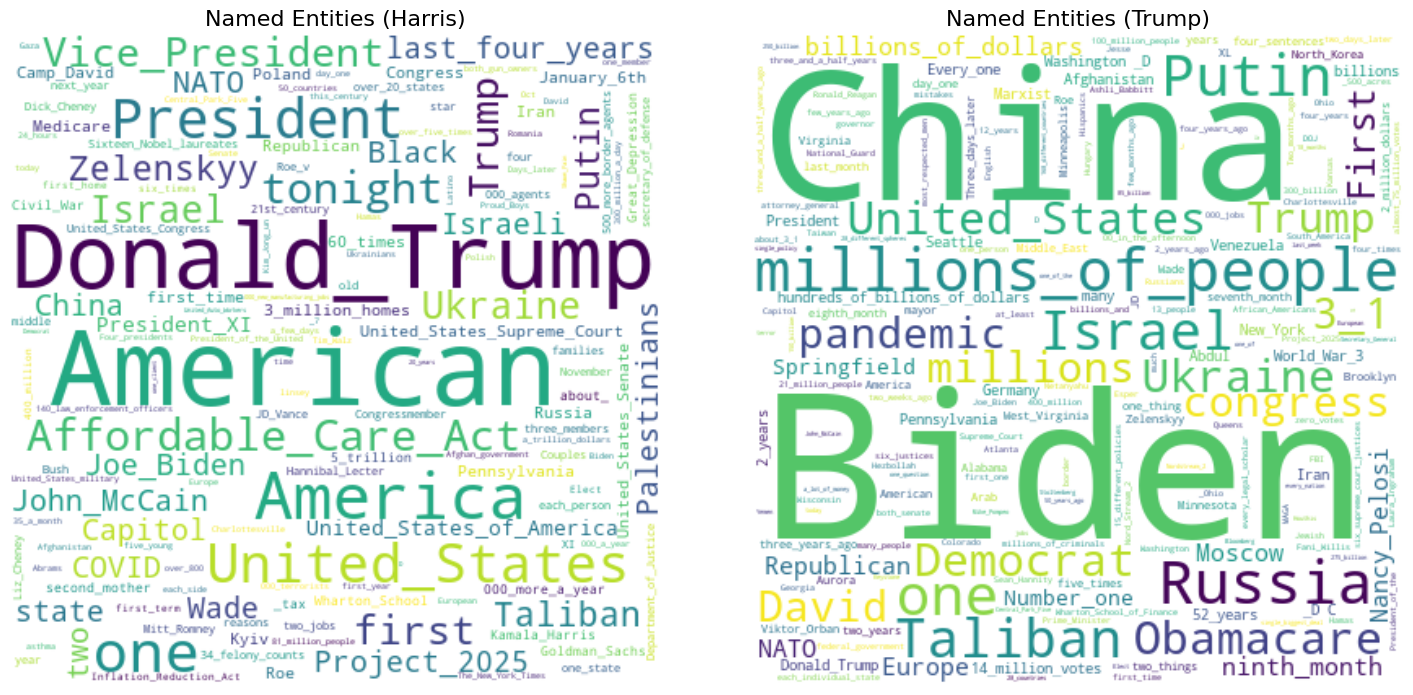

In [17]:
# visualize the wordclouds
from wordcloud import WordCloud

# create Harris and Trump wordclouds
wc_harris = WordCloud(
    width=400,
    height=400,
    background_color='white'
).generate(' '.join([p.replace(' ', '_') for p in harris_entities_ls]))

wc_trump = WordCloud(
    width=400,
    height=400,
    background_color='white'
).generate(' '.join([p.replace(' ', '_') for p in trump_entities_ls]))

# visualize
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))
ax = ax.ravel()

ax[0].imshow(wc_harris, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Named Entities (Harris)', fontsize=16)

ax[1].imshow(wc_trump, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Named Entities (Trump)', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()